<a href="https://colab.research.google.com/github/velozo27/TCC-Pedro-Velozo-ENG1132/blob/main/SRCNN_Comentada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instalação de dependências

In [3]:
# coloquei as dependencias em um arquivo separado
!pip install -r requirements.txt

## Imports

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.io import read_image
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
from datetime import datetime
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from patchify import patchify
from torchvision.transforms import Compose, ToTensor, Resize
import pandas as pd
import time
import re
from pathlib import Path

# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
# garantir que é cuda
assert device == "cuda"
# Test if we are running on colab or not
try:
    from google.colab import files
    from google.colab import drive
    drive.mount("/content/gdrive")
    DATASET_ROOT="/content/gdrive/MyDrive/TCC/datasets/"
except ModuleNotFoundError:
    DATASET_ROOT="./datasets/"

# Criando os patches

(patches já foram criados, não precisa rodar)

In [50]:
def create_image_patches(img_dir: str, patch_size: tuple[int, int, int], output_path: str, num_patches: int) -> None:
    """
    Creates patches from images in a given directory and saves them to a new directory.

    Args:
        img_dir (str): The path to the directory containing the images.
        patch_size (tuple): The desired size of each patch.
        num_patches (int): The number of patches to extract from each image.
    """
    # Create a new directory to store the patches
    patch_dir = os.path.join(output_path, "patches")
    os.makedirs(patch_dir, exist_ok=True)

    # Loop through each image in the directory
    files = os.listdir(img_dir)
    files.sort()
    for img_name in tqdm(files):
        try:
          # if the file is not an image then skip to next iteration
          if os.path.isdir(img_name):
            continue 

          # Load the image
          img_path = os.path.join(img_dir, img_name)
          img = np.array(Image.open(img_path))

          # Extract patches from the image using patchify
          patches = patchify(img, patch_size, step=patch_size[0])

          # Shuffle the patches !!!
          patches = patches.reshape(-1, patch_size[0], patch_size[1], patch_size[2])
          patches = patches[np.random.permutation(patches.shape[0])]

          # Save the patches to the new directory
          img_patch_dir = os.path.join(patch_dir, f"{os.path.splitext(img_name)[0]}_patch")
          os.makedirs(img_patch_dir, exist_ok=True)

          for i in range(min(patches.shape[0], num_patches)):
            patch = patches[i]
            patch = Image.fromarray(patch)
            save_path = os.path.join(img_patch_dir, f"patch_{i}.png")

            patch.save(save_path)

        except IsADirectoryError:
          continue


In [58]:
%time
# otimizacao: criar patches de treino, validacao e teste de uma vez: (32, 8, 2)
create_image_patches(f"{DATASET_ROOT}/Flickr2K", (33, 33, 3), f"{DATASET_ROOT}/Flickr2K_train", 32)
create_image_patches(f"{DATASET_ROOT}/Flickr2K", (33, 33, 3), f"{DATASET_ROOT}/Flickr2K_validation", 8)
# create_image_patches(f"{DATASET_ROOT}/DIV2K_valid_HR", (33, 33, 3), 10)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.34 µs


100%|██████████| 2651/2651 [02:47<00:00, 15.85it/s]


# ***SRCNN***

In [2]:
class SRCNN(nn.Module):
    def __init__(self, initialization="normal") -> None:
        super(SRCNN, self).__init__()
        # 4.3 Model and Performance Trade-offs
        # Based on the basic network settings (i.e., f1 = 9, f2 = 1, f3 = 5, n1 = 64, and n2 = 32),
        f1 = 9
        f2 = 1
        f3 = 5
        #n1 = 64
        n1 = 3
        n2 = 32

        self.initialization = initialization

        self.model = nn.Sequential(
            # 3.1.1 Patch extraction and representation
            nn.Conv2d(in_channels=3, out_channels=n1,
                      #kernel_size=(f1, f1), padding=(f1-1)//2),
                      kernel_size=(f1, f1), padding=0,),
            # nn.ReLU(),

            # # 3.1.2 Non-linear mapping
            # nn.Conv2d(in_channels=n1, out_channels=n2,
            #           #kernel_size=(f2, f2), padding=(f2-1)//2),
            #           kernel_size=(f2, f2), padding=0,),
            # nn.ReLU(),

            # # 3.1.3 Reconstruction
            # nn.Conv2d(in_channels=n2, out_channels=3,
            #           #kernel_size=(f3, f3), padding=(f3-1)//2),
            #           kernel_size=(f3, f3), padding=0),
        )

        self._init_weights()

    def _init_weights(self):
      # The filter weights of each layer are initialized by drawing randomly 
      # from a Gaussian distribution with zero mean and standard deviation 0.001 (and 0 for biases)
      for module in self.modules():
        if isinstance(module, nn.Conv2d):
          if self.initialization == "normal":
            module.weight.data.normal_(mean=0.0, std=0.001)
          elif self.initialization == "xavier":
            nn.init.xavier_normal_(module.weight.data)
          else:
            nn.init.eye_(module.weight.data)

          if module.bias is not None:
              module.bias.data.zero_()

    def print_weights(self):
      for module in self.modules():
       if isinstance(module, nn.Conv2d):
          print(module.weight)

    def forward(self, x: torch.Tensor):
        x = self.model(x)
        return x


# Loops de **Treino** e Validação

In [3]:
def train_loop(dataloader, model, loss_fn, optimizer, device="cuda" if torch.cuda.is_available() else "cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    print(f"Training on {size} samples...")
    print("Batch size:", dataloader.batch_size)
    print("Number of batches:", num_batches)

    train_loss = 0
    for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = X.to(device)
        #print("X", X.shape, X.get_device())
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        train_loss += loss.item()

        # Backpropagation
        # optimizer.zero_grad()
        # loss.backward()
        # optimizer.step()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= num_batches

    # return avg loss
    print(f"Training Error: \n Avg loss: {train_loss:>8f} \n")
    return train_loss

# will also be used for testing (maybe)
def validation_loop(dataloader, model, loss_fn, device="cuda" if torch.cuda.is_available() else "cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    validation_loss = 0

    with torch.no_grad(), tqdm(total=num_batches) as progress_bar:
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            validation_loss += loss_fn(pred, y).item()
            progress_bar.update(1)

    validation_loss /= num_batches

    print(f"Validation Error: \n Avg loss: {validation_loss:>8f} \n")
    return validation_loss


# CustomImageDataset

In [4]:
import os
from PIL import Image

def read_image_aux(file_path):
    """
    Reads and loads an image file from the specified path.

    Args:
        file_path (str): The path to the image file.

    Returns:
        PIL.Image.Image: The loaded image.
    """
    try:
        image = Image.open(file_path)
        return image
    except (IOError, OSError) as e:
        # Handle empty or corrupted files
        raise ValueError(f"Error loading image file: {file_path}. Reason: {str(e)}")


def get_image_patch(img_dir, img_index=-1, patch_index=-1):
    """
    Gets an image from a dataset.

    Args:
        dataset (Dataset): The dataset to get the image from.
        index (int): The index of the image to get.

    Returns:
        Tensor: The image.
    """
    imgs_dir = os.path.join(img_dir, "patches")
    print(imgs_dir)
    imgs = list(os.listdir(imgs_dir))
    if img_index == -1:
      img_index = np.random.randint(0, len(imgs))

    patches_dir = os.path.join(imgs_dir, imgs[img_index])
    print(patches_dir)

    patches = list(os.listdir(patches_dir))
    if patch_index == -1:
      patch_index = np.random.randint(0, len(patches))
    return read_image(os.path.join(patches_dir, patches[patch_index]))

In [5]:
class CustomImageDataset(Dataset):
    """
    A PyTorch dataset for loading a directory of images.

    Args:
        img_dir (str): The path to the directory containing the images.
        transform (callable, optional): A function/transform that takes in an image and returns a
            transformed version. Default: None.
        target_transform (callable, optional): A function/transform that takes in the target and
            transforms it. Default: None.
    """

    def __init__(self, img_dir: str, patches_per_image = None | int, transform = None, target_transform = None, use_patches = True ):
        """
        Initializes a new instance of the CustomImageDataset class.

        Args:
            img_dir (str): The path to the directory containing the images.
            transform (callable, optional): A function/transform that takes in an image and returns a
                transformed version. Default: None.
            target_transform (callable, optional): A function/transform that takes in the target and
                transforms it. Default: None.
        """
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.patches_per_image = patches_per_image
        self.file_lst = self._create_file_list() if use_patches else list(os.listdir(img_dir))

    def __len__(self) -> int:
        """
        Returns the number of images in the dataset.

        Returns:
            The number of images in the dataset.
        """
        return len(self.file_lst)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Returns the image at the specified index in the dataset.

        Args:
            idx (int): The index of the image to return.

        Returns:
            A tuple containing the transformed input image and the transformed target image.
        """
        img_path = self.file_lst[idx]

        image = read_image(f"{self.img_dir}/{img_path}")
        image_x = image.detach().clone()
        image_y = image.detach().clone()

        if self.transform:
            image_x = self.transform(image_x)
        if self.target_transform:
            image_y = self.target_transform(image_y)

        # print(image_x.shape, image_y.shape)
        # print(image_x.dtype, image_y.dtype)
        # print(image_x.max(), image_y.max())

        return image_x.float() / 255, image_y.float() / 255

    def _create_file_list(self):
      """
      Creates a list of files to load, taking into account any patches that have been created.

      Returns:
          A list of file paths to load.
      """
      all_patches_dir = f"{self.img_dir}/patches"
      if not os.path.exists(all_patches_dir) or not os.path.isdir(all_patches_dir):
          return list(os.listdir(self.img_dir))

      file_list = []
      for patch_path in list(os.listdir(all_patches_dir)):
        one_patch_full_dir = f"{all_patches_dir}/{patch_path}"
        one_path_relative_dir = f"patches/{patch_path}"
        
        patches_list = list(os.listdir(one_patch_full_dir))
        
        for index, patch in enumerate(patches_list):
          image_path = f"{one_path_relative_dir}/{patch}"

          # checking if the image is an integral state
          file_size = Path(f"{self.img_dir}/{image_path}").stat().st_size

          if (file_size == 0):
            print(f"Error loading image file: {self.img_dir}/{image_path}. Reason: file has size 0")
            continue

          if self.patches_per_image and index == self.patches_per_image:
            break

          file_list.append(image_path)

      return file_list

# ImageHelper
Métodos auxiliares para exibir imagens

In [6]:
class ImageHelper:
    """
    A helper class for working with image data in PyTorch.
    """

    def __init__(self):
        """
        Initializes a new instance of the ImageHelper class.
        """
        return

    def show_tensor_as_image(self, tensor: torch.Tensor):
        """
        Displays an image represented as a PyTorch tensor.

        Args:
            tensor: A PyTorch tensor representing the image. The tensor should have shape (C, H, W),
                where C is the number of channels, H is the height, and W is the width.

        Returns:
            None
        """
        plt.figure()

        if torch.is_tensor(tensor):
          tensor_np = tensor.detach().numpy()
        else:
          tensor_np = tensor.numpy()
          
        plt.imshow(tensor_np.transpose((1, 2, 0)))
        plt.show()

    def tensor_as_image(self, tensor: torch.Tensor):
        """
        Converts tenso to image
        """
        if torch.is_tensor(tensor):
          tensor_np = tensor.detach().numpy()
        else:
          tensor_np = tensor.numpy()
        return tensor_np.transpose((1, 2, 0))


ImageHelperInstance = ImageHelper()

# Criando os ***Dataset*'s**

In [7]:
%%time
transform_x = transforms.Compose([
    # downscale by factor of 3 (from 33x33 to 11x11 back to 33x33)
    # resize image to 11x11 and downsample by BICUBIC interpolation
    transforms.Resize((11, 11), interpolation=Image.BICUBIC),
    # resize image to 33x33
    transforms.Resize((33, 33), interpolation=Image.BICUBIC)
])

transform_y = transforms.Compose([
    #transforms.Resize((33, 33), interpolation=Image.BICUBIC)
    #transforms.CenterCrop((21, 21))
    transforms.CenterCrop((25, 25))
])

# Set up the data loaders
train_data_set = CustomImageDataset(
    img_dir=f"{DATASET_ROOT}/Flickr2K_train", transform=transform_x, target_transform=transform_y)
validation_data_set = CustomImageDataset(
    img_dir=f"{DATASET_ROOT}/Flickr2K_validation", transform=transform_x, target_transform=transform_y)

train_dataloader = DataLoader(train_data_set, batch_size=2**13, shuffle=True)
validation_dataloader = DataLoader(validation_data_set, batch_size=2**13)

# Report split sizes
print('Training set has {} instances'.format(len(train_data_set)))
print('Validation set has {} instances'.format(len(validation_data_set)))

Training set has 84800 instances
Validation set has 21200 instances
CPU times: user 413 ms, sys: 203 ms, total: 615 ms
Wall time: 731 ms


## Instanciando o modelo

In [8]:
# Instancianting the model
# Atencao: cuidado ao rodar o treino várias vezes sem resetar o modelo!
model = SRCNN(initialization="normal")
model.to(device)

# hyperparameters
#https://stackoverflow.com/questions/48324152/pytorch-how-to-change-the-learning-rate-of-an-optimizer-at-any-given-moment-no
lr = 1e-3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./datasets//Flickr2K_train/patches
./datasets//Flickr2K_train/patches/000560_patch
<class 'torch.Tensor'> torch.Size([3, 33, 33]) torch.float32 tensor(0.0235) tensor(0.3412)
<class 'torch.Tensor'> torch.Size([1, 3, 25, 25]) torch.float32 tensor(-0.0023, device='cuda:0') tensor(0.0037, device='cuda:0')


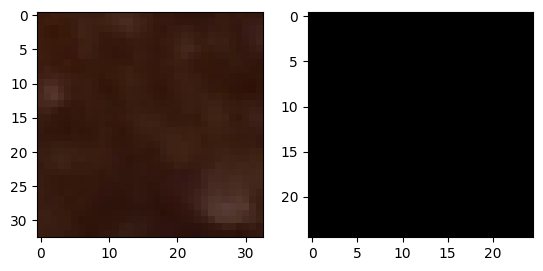

In [125]:
img = get_image_patch(f"{DATASET_ROOT}/Flickr2K_train").float()/255
print(type(img), img.shape, img.dtype, img.min(), img.max())
with torch.no_grad():
  img_out = model(img.unsqueeze(0).to(device))
print(type(img_out), img_out.shape, img_out.dtype, img_out.min(), img_out.max())
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(ImageHelperInstance.tensor_as_image(img.cpu()))
plt.subplot(1, 2, 2)
plt.imshow(ImageHelperInstance.tensor_as_image(img_out.squeeze().cpu()))
plt.show()

# Criando o *Optmizer* e a *loss function* (MSE)

In [9]:
# otimizacao: Mudar o otimizador para Adam ou RMSProp
#           : Usar momentum = 0.9
#           : Usar learning maior: 1e-4?
#           : Usar learning rate decay

# 3.3 Training
# The loss is minimized using stochastic gradient descent with the standard backpropagation
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# we use Mean Squared Error (MSE) as the loss function:
loss_fn = nn.MSELoss()
loss_fn.to(device)

MSELoss()

# Exemplos de imagem de baixa e alta resolução do dataset de treino

<class 'torch.Tensor'> torch.Size([8192, 3, 33, 33]) torch.float32 tensor(0.) tensor(1.)
<class 'torch.Tensor'> torch.Size([8192, 3, 25, 25]) torch.float32 tensor(0.) tensor(1.)
<class 'torch.Tensor'> torch.Size([8192, 3, 33, 33]) torch.float32 tensor(0.) tensor(1.)
<class 'torch.Tensor'> torch.Size([8192, 3, 25, 25]) torch.float32 tensor(0.) tensor(1.)


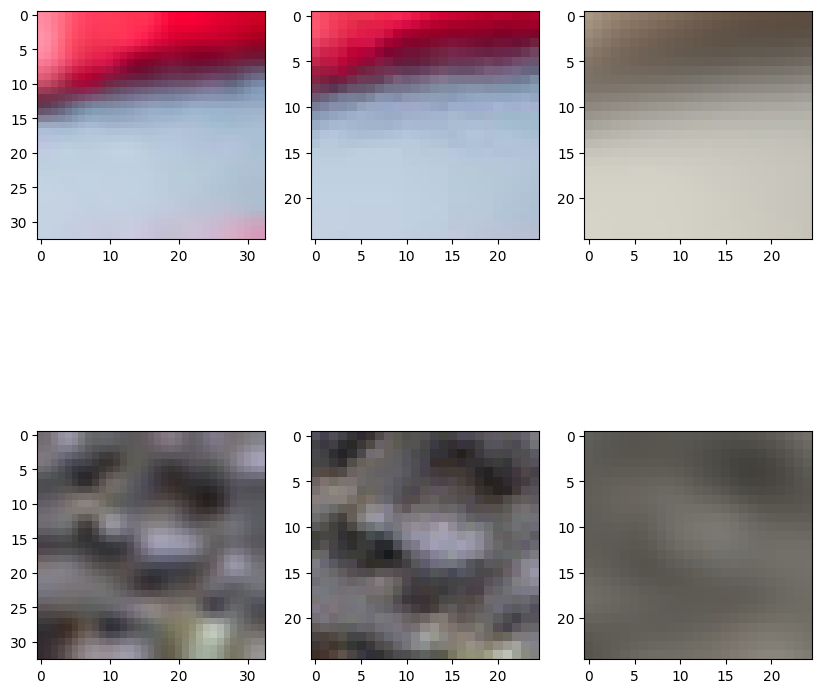

In [12]:
# example of training image
num_samples = 2
fig, axes = plt.subplots(num_samples, 3, figsize=(10, 10))
for i, (X, y) in enumerate(train_dataloader):
    with torch.no_grad():
        z = model.forward(X.to(device))
    print(type(X), X.shape, X.dtype, X.min(), X.max())
    print(type(y), y.shape, y.dtype, y.min(), y.max())
    axes[i, 0].imshow(ImageHelperInstance.tensor_as_image(X[0]))
    axes[i, 1].imshow(ImageHelperInstance.tensor_as_image(y[0]))
    axes[i, 2].imshow(ImageHelperInstance.tensor_as_image(z[0].cpu()))
    # axes[i, 0].set_axis_off()
    if i == num_samples - 1:
        break
plt.show()

# Carregando o modelo

## Carregando a última *epoch* executada

- Função para pegar a epoch que paramos de executar na última sessão

In [162]:
def get_epoch_number_from_path(s: str) -> int or None:
    epoch_pattern = r"epoch=(\d+)"
    match = re.search(epoch_pattern, s)

    if match:
        epoch_number = int(match.group(1))
        return epoch_number
    else:
        return None

- Os arquivos estão sendo salvos no drive como no comando abaixo, a função `get_epoch_number_from_path` acima extrai o número da epoch através do nome do arquivo

In [163]:
os.listdir('/content/gdrive/My Drive/TCC/code/models/SRCNN/testing/train_session_testing/models')

['2023-05-18_00:35:30_epoch=0_srcnn_avg_train_loss_0.25221318579637086_avg_validation_loss_0.15420054892698923',
 '2023-05-18_00:36:00_epoch=1_srcnn_avg_train_loss_0.2514351961704401_avg_validation_loss_0.15417732670903206',
 '2023-05-18_00:36:31_epoch=2_srcnn_avg_train_loss_0.24989220041495103_avg_validation_loss_0.15415425971150398',
 '2023-05-18_00:37:02_epoch=3_srcnn_avg_train_loss_0.2488373059492845_avg_validation_loss_0.15413117657105127',
 '2023-05-18_00:37:32_epoch=4_srcnn_avg_train_loss_0.2528951225372461_avg_validation_loss_0.15410792703429857',
 '2023-05-18_00:46:34_epoch=0_srcnn_avg_train_loss_0.24937577660267168_avg_validation_loss_0.15403849259018898',
 '2023-05-18_00:47:04_epoch=1_srcnn_avg_train_loss_0.2550358474254608_avg_validation_loss_0.15401514743765196',
 '2023-05-18_00:47:35_epoch=2_srcnn_avg_train_loss_0.250308381823393_avg_validation_loss_0.15399201959371567',
 '2023-05-18_00:48:06_epoch=3_srcnn_avg_train_loss_0.25209607298557574_avg_validation_loss_0.153968842

In [164]:
# finding the most recent epoch model
directory = '/content/gdrive/My Drive/TCC/code/models/SRCNN/testing/train_session_testing/models'

most_recent_epoch = -1
model_load_path_name = ''
# model_load_path_name = f"{directory}/"
for filename in os.listdir(directory):
    epoch = get_epoch_number_from_path(filename)
    if epoch is not None and epoch > most_recent_epoch:
        most_recent_epoch = epoch
        model_load_path_name = os.path.join(directory, filename)

print("Most recent epoch:", most_recent_epoch)
print("Model load path name:", model_load_path_name)

Most recent epoch: 4
Model load path name: /content/gdrive/My Drive/TCC/code/models/SRCNN/testing/train_session_testing/models/2023-05-18_00:37:32_epoch=4_srcnn_avg_train_loss_0.2528951225372461_avg_validation_loss_0.15410792703429857


In [165]:
if not model_load_path_name:
  print('model_load_path_name does not exist. This a new training instance')
elif torch.cuda.is_available():
  model.load_state_dict(torch.load(model_load_path_name))
else:
  model.load_state_dict(torch.load(model_load_path_name, map_location=torch.device('cpu')))


# **Treinamento** 

## Salvando o Dataframe no drive e localmente para cada *epoch*

In [38]:
def download_df(df, train_loss, validation_loss, epoch):
  date = datetime.today().strftime('%Y-%m-%d %H:%M:%S').replace(' ', '_')
  file_name = f'SRCNN_epoch={epoch}_{date}_srcnn_avg_train_loss_{train_loss}_avg_validation_loss_{validation_loss}.csv'
  df.to_csv(file_name)
  files.download(file_name)

Para executar o salvamento do Dataframe, lemos do drive o último .csv salvo, e adicionamos uma linha nele e salvamos novamente.

Obs: Para testes rápido com datasets pequenos, o tempo de leitura do dataframe no drive parece ser mais rápido que o tempo de escrita, o que gerava uma concorrência, para resolver isso, adicionei um `SLEEP_TIME` para esperar um tempo após cada escrita. 

In [100]:
SLEEP_TIME = 30

def save_df(df_path, train_loss, validation_loss, epoch, epoch_duration):
    # Check if the file exists
    if not os.path.isfile(df_path):
        df = pd.DataFrame({'Train Loss': [train_loss], 'Validation Loss': [validation_loss], 'epoch': [epoch], 'epoch_duration [s]': [epoch_duration]})
        download_df(df, train_loss, validation_loss, epoch) # for backup
        df.to_csv(df_path, index=False)
        time.sleep(SLEEP_TIME) # stop concurrency attempt
        return

    df = pd.read_csv(df_path)
    new_df_rows = {'Train Loss': [train_loss], 'Validation Loss': [validation_loss], 'epoch': [epoch], 'epoch_duration [s]': [epoch_duration]}
    df = df.append(pd.DataFrame(new_df_rows))
    download_df(df, train_loss, validation_loss, epoch) # for backup
    df.to_csv(df_path, index=False)
    time.sleep(SLEEP_TIME) # stop concurrency attempt
    

## Execução das *epochs*
- Execução dos loops de treinamento e validação, e também salvamentos dos dados

In [101]:
starting_epoch = get_epoch_number_from_path(model_load_path_name)
if starting_epoch is not None:
  starting_epoch = starting_epoch + 1 # add 1 because we are starting after the epoch we left of

print('starting_epoch =', starting_epoch)

starting_epoch = None


epoch 0
-------------------------------
Training on 84800 samples...
Batch size: 8192
Number of batches: 11


100%|██████████| 11/11 [00:39<00:00,  3.60s/it]


Training Error: 
 Avg loss: 0.189222 



100%|██████████| 3/3 [00:08<00:00,  2.96s/it]


Validation Error: 
 Avg loss: 0.114853 

epoch 1
-------------------------------
Training on 84800 samples...
Batch size: 8192
Number of batches: 11


100%|██████████| 11/11 [00:39<00:00,  3.63s/it]


Training Error: 
 Avg loss: 0.082898 



100%|██████████| 3/3 [00:07<00:00,  2.67s/it]


Validation Error: 
 Avg loss: 0.053767 

epoch 2
-------------------------------
Training on 84800 samples...
Batch size: 8192
Number of batches: 11


100%|██████████| 11/11 [00:36<00:00,  3.28s/it]


Training Error: 
 Avg loss: 0.041003 



100%|██████████| 3/3 [00:08<00:00,  2.84s/it]


Validation Error: 
 Avg loss: 0.029622 

epoch 3
-------------------------------
Training on 84800 samples...
Batch size: 8192
Number of batches: 11


100%|██████████| 11/11 [00:34<00:00,  3.10s/it]


Training Error: 
 Avg loss: 0.024489 



100%|██████████| 3/3 [00:10<00:00,  3.34s/it]


Validation Error: 
 Avg loss: 0.020016 

epoch 4
-------------------------------
Training on 84800 samples...
Batch size: 8192
Number of batches: 11


100%|██████████| 11/11 [00:35<00:00,  3.24s/it]


Training Error: 
 Avg loss: 0.017840 



100%|██████████| 3/3 [00:09<00:00,  3.03s/it]


Validation Error: 
 Avg loss: 0.016143 

epoch 5
-------------------------------
Training on 84800 samples...
Batch size: 8192
Number of batches: 11


100%|██████████| 11/11 [00:37<00:00,  3.41s/it]


Training Error: 
 Avg loss: 0.015155 



100%|██████████| 3/3 [00:10<00:00,  3.38s/it]


Validation Error: 
 Avg loss: 0.014516 

epoch 6
-------------------------------
Training on 84800 samples...
Batch size: 8192
Number of batches: 11


100%|██████████| 11/11 [00:38<00:00,  3.52s/it]


Training Error: 
 Avg loss: 0.013997 



100%|██████████| 3/3 [00:10<00:00,  3.34s/it]


Validation Error: 
 Avg loss: 0.013766 

epoch 7
-------------------------------
Training on 84800 samples...
Batch size: 8192
Number of batches: 11


100%|██████████| 11/11 [00:34<00:00,  3.12s/it]


Training Error: 
 Avg loss: 0.013417 



100%|██████████| 3/3 [00:08<00:00,  2.79s/it]


Validation Error: 
 Avg loss: 0.013364 

epoch 8
-------------------------------
Training on 84800 samples...
Batch size: 8192
Number of batches: 11


100%|██████████| 11/11 [00:39<00:00,  3.56s/it]


Training Error: 
 Avg loss: 0.013078 



100%|██████████| 3/3 [00:08<00:00,  2.86s/it]


Validation Error: 
 Avg loss: 0.013100 

epoch 9
-------------------------------
Training on 84800 samples...
Batch size: 8192
Number of batches: 11


100%|██████████| 11/11 [00:34<00:00,  3.17s/it]


Training Error: 
 Avg loss: 0.012870 



100%|██████████| 3/3 [00:09<00:00,  3.15s/it]


Validation Error: 
 Avg loss: 0.012892 

epoch 10
-------------------------------
Training on 84800 samples...
Batch size: 8192
Number of batches: 11


100%|██████████| 11/11 [00:40<00:00,  3.64s/it]


Training Error: 
 Avg loss: 0.012679 



100%|██████████| 3/3 [00:07<00:00,  2.66s/it]


Validation Error: 
 Avg loss: 0.012707 

epoch 11
-------------------------------
Training on 84800 samples...
Batch size: 8192
Number of batches: 11


100%|██████████| 11/11 [00:36<00:00,  3.29s/it]


Training Error: 
 Avg loss: 0.012501 



100%|██████████| 3/3 [00:10<00:00,  3.57s/it]


Validation Error: 
 Avg loss: 0.012535 

epoch 12
-------------------------------
Training on 84800 samples...
Batch size: 8192
Number of batches: 11


100%|██████████| 11/11 [00:37<00:00,  3.41s/it]


Training Error: 
 Avg loss: 0.012332 



100%|██████████| 3/3 [00:09<00:00,  3.05s/it]


Validation Error: 
 Avg loss: 0.012370 

epoch 13
-------------------------------
Training on 84800 samples...
Batch size: 8192
Number of batches: 11


100%|██████████| 11/11 [00:40<00:00,  3.66s/it]


Training Error: 
 Avg loss: 0.012162 



100%|██████████| 3/3 [00:09<00:00,  3.32s/it]


Validation Error: 
 Avg loss: 0.012210 

epoch 14
-------------------------------
Training on 84800 samples...
Batch size: 8192
Number of batches: 11


100%|██████████| 11/11 [00:33<00:00,  3.01s/it]


Training Error: 
 Avg loss: 0.012019 



100%|██████████| 3/3 [00:10<00:00,  3.34s/it]

Validation Error: 
 Avg loss: 0.012055 

Done!


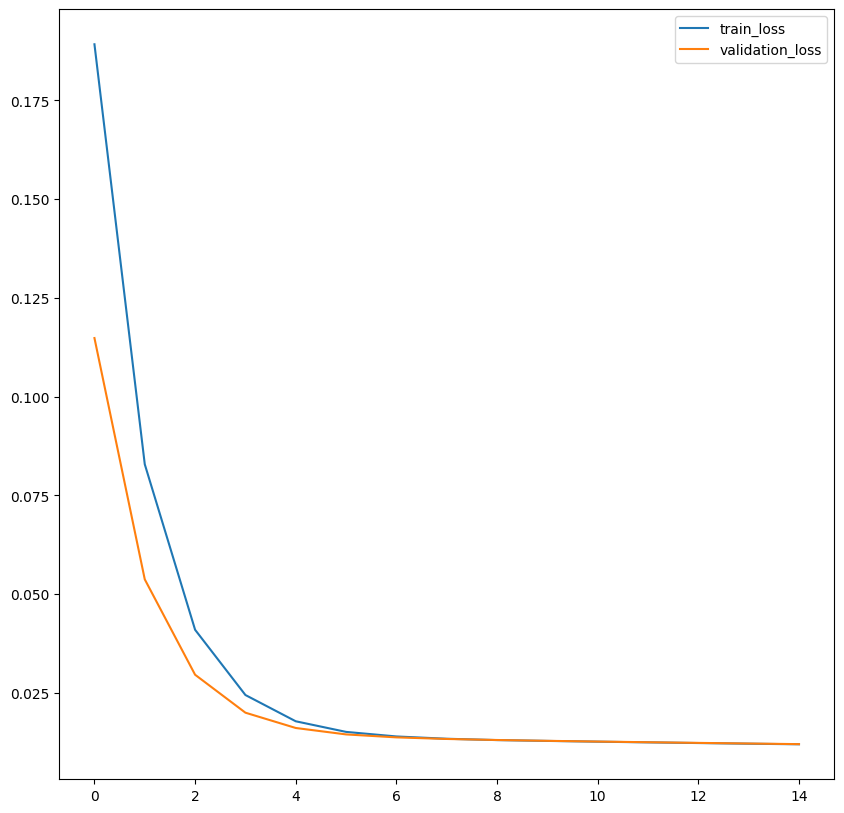

CPU times: user 2h 32min 2s, sys: 43.8 s, total: 2h 32min 46s
Wall time: 11min 35s


In [11]:
%%time
train_loss = 0
validation_loss = 0
epochs = 15

# melhor usar lista e depois converter para array
train_loss_array = list()
validation_loss_array = list()
for t in range(epochs):
    # # # finding the current epoch number logic
    # # if index == 0 and starting_epoch is none:
    # #   current_epoch = 0
    # #   starting_epoch = 0
    # # elif starting_epoch >= 0:  
    # #   current_epoch = starting_epoch + t
    # # else:
    # #   current_epoch = 0

    # print(f"\nepoch {current_epoch}\n-------------------------------")

    start_time = time.time()  # Start timing the epoch

    print(f"epoch {t}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    validation_loss = validation_loop(validation_dataloader, model, loss_fn)
    # print('validation_loss =', validation_loss)
    
    train_loss_array.append(train_loss)
    validation_loss_array.append(validation_loss)

    # df_path = '/content/gdrive/My Drive/TCC/code/models/SRCNN/testing/train_session_testing/SRCNN_train_vs_validation_loss.csv'

    elapsed_time = time.time() - start_time  # Calculate elapsed time for the epoch

    # print(f'elapsed_time for epoch {current_epoch} = {elapsed_time}')

    # save_df(df_path, train_loss, validation_loss, current_epoch, elapsed_time)

    # saving each epoch, since it's taking forever to train
    # date = datetime.today().strftime('%Y-%m-%d %H:%M:%S').replace(' ', '_')
    # model_save_path_name = f"{directory}/{date}_epoch={current_epoch}_srcnn_avg_train_loss_{train_loss}_avg_validation_loss_{validation_loss}"
    # torch.save(model.state_dict(), model_save_path_name)
    
print("Done!")

train_loss_array = np.array(train_loss_array)
validation_loss_array = np.array(validation_loss_array)

plt.figure(figsize=(10, 10))
plt.plot(range(len(train_loss_array)), train_loss_array, label='train_loss')
plt.plot(range(len(validation_loss_array)), validation_loss_array, label='validation_loss')
plt.legend()
plt.show()

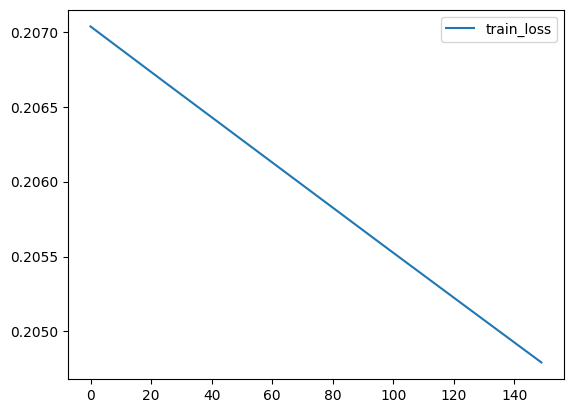

[0.20703546 0.20702027 0.20700508 0.20698989 0.20697473 0.20695957
 0.2069444  0.20692921 0.20691405 0.20689891 0.20688374 0.20686857
 0.20685337 0.20683821 0.20682308 0.20680794 0.20679279 0.20677764
 0.20676249 0.20674734 0.20673216 0.206717   0.20670186 0.20668668
 0.20667155 0.20665647 0.20664138 0.20662627 0.20661111 0.20659598
 0.20658084 0.20656572 0.20655062 0.20653548 0.20652035 0.2065052
 0.2064901  0.20647499 0.20645988 0.20644476 0.20642963 0.20641454
 0.2063994  0.20638427 0.20636916 0.20635408 0.20633896 0.20632386
 0.20630874 0.20629364 0.20627859 0.20626349 0.2062484  0.2062333
 0.20621819 0.20620312 0.20618804 0.20617293 0.20615785 0.20614274
 0.20612767 0.20611255 0.20609747 0.20608243 0.20606735 0.20605227
 0.20603719 0.2060221  0.20600699 0.20599193 0.20597688 0.20596183
 0.2059468  0.20593173 0.20591667 0.20590164 0.20588658 0.20587154
 0.20585649 0.20584141 0.20582636 0.20581133 0.20579627 0.20578124
 0.20576621 0.20575119 0.20573613 0.2057211  0.20570609 0.205691

In [50]:
plt.figure()
plt.plot(range(len(validation_loss_array)), validation_loss_array, label='train_loss')
plt.legend()
plt.show()
print(validation_loss_array)

# Train x Validation Loss


In [169]:
df_path = '/content/gdrive/My Drive/TCC/code/models/SRCNN/testing/train_session_4/SRCNN_train_vs_validation_loss.csv'

df = pd.read_csv(df_path)

In [170]:
df.head()

,Train Loss,Validation Loss,epoch
0,0.216251,0.185749,0
1,0.214914,0.184308,1
2,0.212921,0.182885,2
3,0.211220,0.181479,3
4,0.209583,0.180090,4


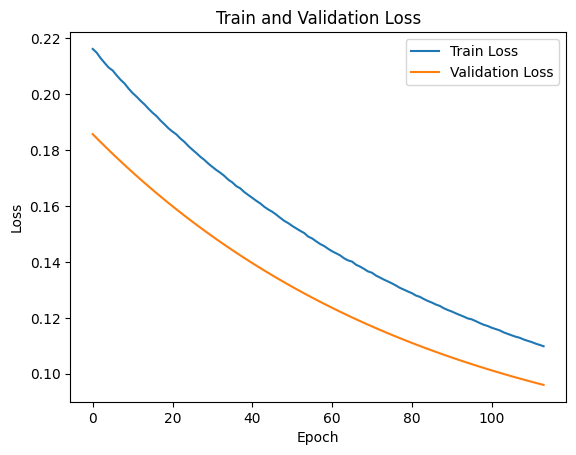

In [171]:
# Plotting the losses
plt.plot(df['epoch'], df['Train Loss'], label='Train Loss')
plt.plot(df['epoch'], df['Validation Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Tesntando o modelo em uma imagem

/tmp/ipykernel_1831459/2283112391.py:5: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use BILINEAR or Resampling.BILINEAR instead.
  transforms.Resize((128, 128), interpolation=Image.LINEAR),
/tmp/ipykernel_1831459/2283112391.py:7: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use BILINEAR or Resampling.BILINEAR instead.
  transforms.Resize((256, 256), interpolation=Image.LINEAR)


torch.Size([3, 256, 256])
246


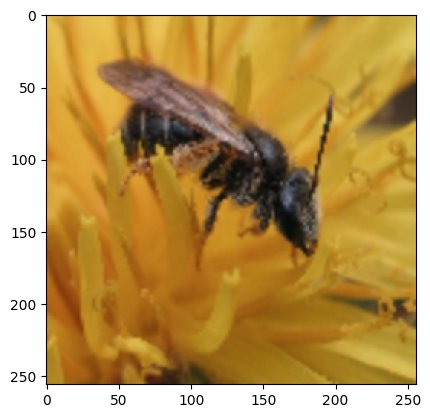

In [110]:
new_image = Image.open(f"{DATASET_ROOT}/Flickr2K/000797.png")
transform = transforms.Compose([
    transforms.ToTensor(),
    # resize image to 33x33 and downsample by BICUBIC interpolation
    transforms.Resize((128, 128), interpolation=Image.LINEAR),
    # resize image to 256x256
    transforms.Resize((256, 256), interpolation=Image.LINEAR)
])


new_image_lr = transform(new_image)
print(new_image_lr.shape)
print(np.array(new_image).max())
ImageHelperInstance.show_tensor_as_image(new_image_lr)


In [52]:
new_image_lr.max()

tensor(0.9337)

In [53]:
new_image_sr = model(new_image_lr.to(device))

In [54]:
new_image_sr.max()

tensor(0.1006, device='cuda:0', grad_fn=<MaxBackward1>)

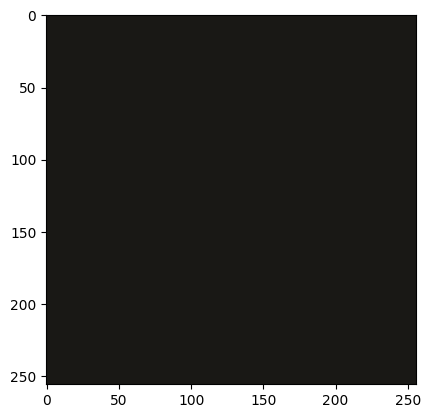

In [55]:
import matplotlib.pyplot as plt

plt.figure()
new_image_sr_np = new_image_sr.cpu().detach().numpy()
new_img = torch.mul(new_image_sr, 3)
plt.imshow(new_image_sr_np.transpose((1, 2, 0)))
plt.show()